# Cumulative Rainfall

A simple exercise to load daily rainfall data for the contiguous US from the National Weather Service (NWS) <https://water.weather.gov/precip/>. The files are in GeoTIFF format.

During the month of May of 2019 the US Midwest received a massive amount of rainfall. Let's see if we can load the maps and compute the cumualtive rainfall for a short period for the entire US. This tutorial will get you started with reading raster maps, generating tri-dimensional Numpy arrays by stacking the multiple raster maps of daily rainfall, and computing the cumulative rainfall along the second axis (third dimension, depth of the stack) of the tri-dimensional array.

**Required packages**

- Rasterio. Install using the following command from the notebook `!pip install rasterio`


In [95]:
# Import modules
import glob
import numpy as np
import matplotlib.pyplot as plt
import rasterio


In [96]:
# Navigate to folder with PRISM files
glob.os.chdir('../datasets/rainfall/')


In [104]:
# List PRISM raster files
prism_files = [file for file in glob.glob("*.tif")]
prism_files


['nws_precip_1day_20190515_conus.tif',
 'nws_precip_1day_20190516_conus.tif',
 'nws_precip_1day_20190517_conus.tif',
 'nws_precip_1day_20190518_conus.tif',
 'nws_precip_1day_20190519_conus.tif',
 'nws_precip_1day_20190520_conus.tif',
 'nws_precip_1day_20190521_conus.tif']

In [267]:
# Load a single raster to get some information about the layer
raster = rasterio.open(prism_files[0])

# Let's print some of the most important attributes of a single raster
print(raster.shape)
print(raster.width)
print(raster.height)
print(raster.indexes)
print(raster.bounds)
print(raster.crs)

# Save some attributes in a variable for later use
rows,cols = raster.shape
idx_no_us = raster.read(1) < 0 # negative values in raster


(881, 1121)
1121
881
(1,)
BoundingBox(left=-1904912.11073866, bottom=-7619986.69569394, right=3434410.88926134, top=-3423783.69569394)
PROJCS["NOAA_HRAP_Grid",GEOGCS["GCS_NOAA_HRAP",DATUM["D_NOAA_HRAP",SPHEROID["Sphere",6371200,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",60],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]


In [269]:
# Create empty matrix
rainfall_3d = np.ones([rows,cols,len(prism_files)]) * np.nan

# Iterate and append rainfall for each day to build a 3D array
for count,filename in enumerate(prism_files):
    raster = rasterio.open(filename)
    rainfall = raster.read(1)
    rainfall[idx_no_us] = np.nan
    rainfall_3d[:,:,count] = rainfall
    

Alternatively you can explore the use of `np.empty` to initialize a 3D Numpy array, the use of `np.dstack()` to append matrices in the third dimension of the array, or even use the `np.concatenate` to append new raster grids to the `axis=2`. Since we know the numer of rows, columns, and the total number of maps that we have from our exploratory raster analysis, I decided to use this information and create an array of `NaN` with the same dimensions as the resulting array. This pre-allocates memory and also avoids concatenating empty grids.

The approach used above assumes that we know the total number of iterations. This approach will not work if we don't know the total number of grids or layers that we need to append beforehand. In that case, `np.dstack()` is probably the best way to go.


In [270]:
# Inspect resulting 3D array
rainfall_3d.shape


(881, 1121, 7)

In [271]:
# Inspect a slice of the 3D array
rainfall_3d[0:5, 0:5, 1]


array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]])

In [276]:
# Compute cumulative rainfall for each single pixel
cum_rainfall = np.nansum(rainfall_3d, axis=2)
cum_rainfall = cum_rainfall * 25.4 # inches to millimeters


In [277]:
# Inspect dimensions and data within the cumulative sum
print(cum_rainfall.shape)
cum_rainfall[0:5,0:5]


(881, 1121)


array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [278]:
# Set to `NaN` all the pixels that are outside the PRISM US boundaries and are equal to zero
cum_rainfall[idx_no_us | (cum_rainfall == 0)] = np.nan


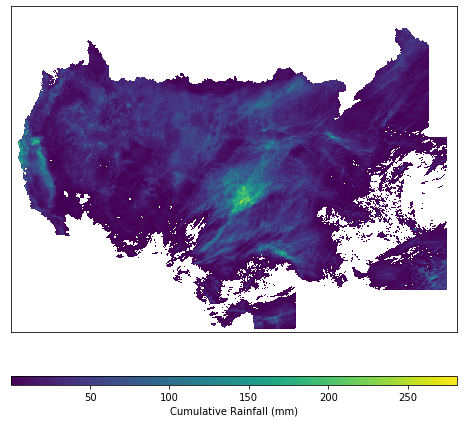

In [279]:
plt.figure(figsize=(8,8))
plt.imshow(cum_rainfall, aspect='auto')
plt.colorbar(orientation="horizontal", pad=0.1, aspect=50, label="Cumulative Rainfall (mm)")
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.show()
